# Kramer's Rate Evaluation of Quality of Collective Variables

Start this notebook with this command:
`env PYTHONPATH=$PATH_TO_MDFEATURE/mdfeature/src jupyter notebook`

e.g. `env PYTHONPATH=/home/dominic/PycharmProjects/mdfeature/src jupyter notebook`

In [3]:
%matplotlib inline
#import metadynamics
from openmm import *
from openmm.app import *
from openmm.unit import *
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.image as image
from pyemma import msm
from scipy.interpolate import griddata
from matplotlib.pyplot import cm
import mdtraj as md
from ipywidgets import IntProgress
from IPython.display import display
import time
import numpy as np

import mdfeature.diffusionmap as diffusionmap

from scipy.optimize import dual_annealing

Evaluation steps:
1. Generate a long MD simulation (or an ensemble of shorter replica simulations)
2. Apply diffusion maps and compute free energy $F(\xi)$
3. Divide by the diffusion coordinates into M boxes and calculate the transitions $N_{ij}$ over a specified time $t_{\alpha}$. Also calculate the probability of being in a particular state, $P_i$.
4. Most probable rate matrix $\mathbf{R}$ identified by a maxmimum likelihood optimisation using Metropolis Monte Carlo
5. Rate matrix coefficients are then used collective-variable dependent diffusion coefficients $D(\xi)$

## 1. Run Simulation

In [4]:
pdb_name = 'alanine.pdb'
save_name = 'trajectory.dcd'

steps = 100
iterations = 100

temperature = 300
beta = 1.0/(temperature*0.0083144621)

def run_simulation(pdb_name, save_name, iterations, steps, temperature, force_fields=['amber14-all.xml', 'amber14/spce.xml']):
    pdb = PDBFile(pdb_name)

    forcefield = ForceField(*force_fields)
    system = forcefield.createSystem(pdb.topology, nonbondedMethod=CutoffNonPeriodic, constraints=HBonds)

    integrator = LangevinIntegrator(temperature*kelvin, 1.0/picosecond, 0.002*picoseconds)
    simulation = Simulation(pdb.topology, system, integrator, platform=Platform.getPlatformByName('CPU'))
    simulation.context.setPositions(pdb.positions)
    simulation.context.setVelocitiesToTemperature(temperature*kelvin)

    mdinit = md.load_pdb(pdb_name)

    mdinit.save_dcd(save_name)     
    simulation.reporters.append(DCDReporter(save_name, steps, append=True))

    max_count = iterations
    bar = IntProgress(min=0, max=max_count) # instantiate the bar
    display(bar) # display the bar

    for i in range(iterations):
        bar.value += 1
        simulation.step(steps)
        state = simulation.context.getState(getEnergy=True, enforcePeriodicBox = False)
        positions = simulation.context.getState(getPositions=True).getPositions()
        
    return simulation

In [5]:
mdinit = md.load_pdb(pdb_name)
simulation = run_simulation(pdb_name='alanine.pdb', save_name='trajectory.dcd', iterations=iterations, steps=steps, temperature=temperature)

IntProgress(value=0)

In [6]:
def open_trajectory_file(traj_file, skip_first=1000, use_test_trajectory=False):
    if use_test_trajectory:
        traj_file = 'test_traj.dcd'
    
    traj_std_tmp = md.load_dcd(traj_file, mdinit.topology)
    traj_orig = traj_std_tmp[skip_first:]
    traj_orig = traj_orig.superpose(traj_orig[0])
    
    return traj_orig

In [7]:
traj = open_trajectory_file(traj_file=save_name, skip_first=10, use_test_trajectory=True)

## 2. Apply Diffusion Maps And Compute $F(\xi)$

In [8]:
# Here we apply a target measure diffusion maps algorithm (TMDmap)

weight_params = {}
weight_params['simulation'] = simulation
weight_params['temperature'] = temperature

dmap_obj, traj_final = diffusionmap.compute_diffusionmaps(traj, nrpoints=2000, epsilon=1.0, weights='compute', weight_params=weight_params)

<mdtraj.Trajectory with 9991 frames, 22 atoms, 3 residues, without unitcells>
Subsampled to
<mdtraj.Trajectory with 2000 frames, 22 atoms, 3 residues, without unitcells>
Computing vanilla diffusionmap


In [9]:
diffusion_coordinate = 0 

# TODO: understand theory behind this step
def compute_marginalised_free_energy_from_diffusion_map(diffusion_map, diffusion_coordinate):
    free_energy_counts, coordinate = np.histogram(diffusion_map.dmap[:,diffusion_coordinate], bins=200)
    with numpy.errstate(divide='ignore'):
        free_energy = -np.log(free_energy_counts)
        
    return free_energy, coordinate[:-1]

Text(0, 0.5, 'Free Energy')

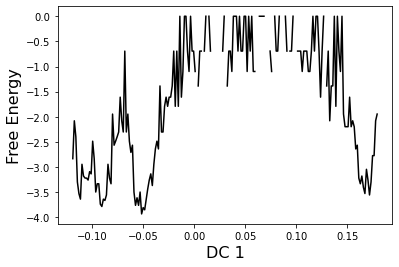

In [10]:
free_energy, coordinate = compute_marginalised_free_energy_from_diffusion_map(dmap_obj, diffusion_coordinate)
plt.plot(coordinate, free_energy, 'k')
plt.xlabel('DC 1', fontsize=16)
plt.ylabel('Free Energy', fontsize=16)

Text(0, 0.5, 'DC 1')

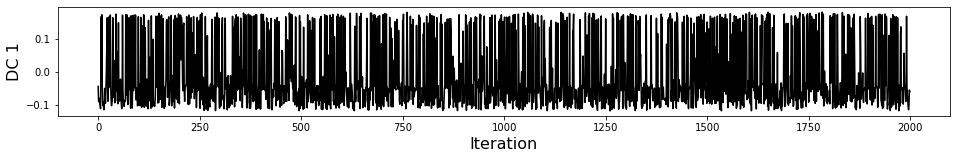

In [11]:
from matplotlib.pyplot import figure
diffusion_coordinate_time_series = dmap_obj.dmap[:,diffusion_coordinate]
fig = plt.figure(figsize=(16,2))
plt.plot(diffusion_coordinate_time_series, 'k')
plt.xlabel('Iteration', fontsize=16)
plt.ylabel('DC 1', fontsize=16)

## 3. Partition Coordinates and Compute $N_{ij}$ and $P_i$

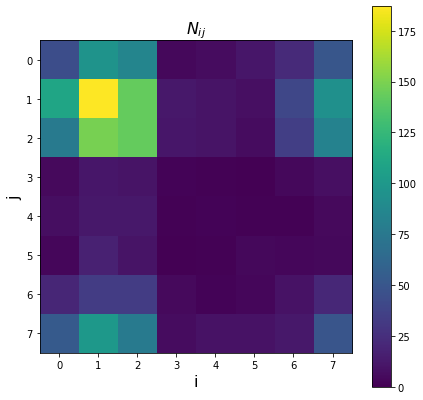

Text(0, 0.5, 'P(i)')

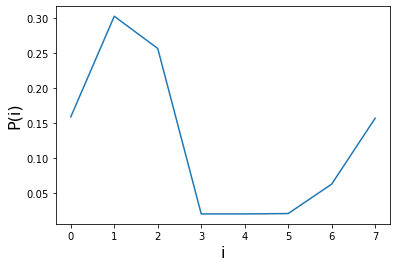

In [12]:
def compute_N_and_P(time_series, observation_interval, cells):
    min_coord = min(time_series)
    max_coord = max(time_series)
    cell_sequence = []
    for coord in time_series:
        cell_sequence.append(round((cells-1)*(coord - min_coord)/(max_coord-min_coord)))

    N = np.zeros((cells, cells))
    state_sequence = [cell for idx, cell in enumerate(cell_sequence) if idx%observation_interval == 0]
    for idx, cell in enumerate(state_sequence[:-1]):
        N[cell, state_sequence[idx+1]]+=1
    
    P = np.zeros(cells)
    for state in cell_sequence:
        P[state] += 1
        
    P = P / np.sum(P)
        
    return N, P
    
t = 1    # the subsampling factor ("observation interval")
    
N, P = compute_N_and_P(time_series=diffusion_coordinate_time_series, observation_interval=t, cells=8)

fig = plt.figure(figsize=(7,7))
plt.imshow(N)
plt.title(r'$N_{ij}$', fontsize=16)
plt.xlabel('i', fontsize=16)
plt.ylabel('j', fontsize=16)
plt.colorbar()
plt.show()

plt.plot(P)
plt.xlabel('i', fontsize=16)
plt.ylabel('P(i)', fontsize=16)


## 4. Identify Most Probable $R_{ij}$ Through Maximum Likelihood Optimisation

The rate matrix $\mathbf{R}$ must satisfy detailed balance: for a given probability vector $P$, we have that $\mathbf{R}$ has $N(N-1)/2$ free coefficients with matrix elements defined as:

$$
R_{ij} =
\begin{cases}
R_{ij} > 0 &\text{if}\; i>j \\
- \sum_{l\neq i}R_{li} &\text{if}\; i=j \\
R_{ji}P_i/P_j &\text{if}\; i < j
\end{cases}.
$$

Now define the symmetric matrix $\tilde{R}_{ij} = P^{-1/2}_i R_{ij} P_j^{1/2}$ whose matrix of real eigenvectors $U$ satisfies $\mathbf{\tilde{R}}\mathbf{U} = \mathbf{U}\mathbf{\Lambda}$, where $\mathbf{\Lambda}=\text{diag}\left(\lambda_1, ..., \lambda_N\right)$. It follows that $e^{t\mathbf{\tilde{R}}}=\mathbf{U}e^{t\mathbf{\Lambda}}\mathbf{U}^T$ and so $e^{t\mathbf{R}}=\text{diag}\left(P_1^{1/2}, ..., P_N^{1/2}\right)e^{t\mathbf{\tilde{R}}}\text{diag}\left(P_1^{-1/2},...,P_N^{-1/2}\right)$ which can be calculated by diagonalisation of the real symmetric matrix $\mathbf{\tilde{R}}$.

The log-likelihood function associated with the observed $N_{ij}$ for a given rate matrix $\mathbf{R}$ is then:

$$
\ln{L} = \sum_{i=1}^{m}\sum_{j=1}^m N_{ij} \ln{\left(e^{tR}\right)_{ij}}.
$$

In [33]:
def convert_R_components_to_matrix(R_components, P, matrix_dimension):
    R = np.zeros((matrix_dimension, matrix_dimension))
    component_number = 0
    for i in np.arange(0,matrix_dimension-1,1):
        n = matrix_dimension - i
        for j in range(i+1,i+n):
            R[i][j] = R_components[component_number]
            R[j][i] = R_components[component_number] * P[i] / P[j]
            component_number += 1
            
    row_sums = np.sum(R, axis=1)
    for i in range(matrix_dimension):
        R[i][i] = - row_sums[i]
        
    return R
                


def negative_log_likelihood(R, *args):
    # R is a 1D array
    N = args[0]
    P = args[1]
    t = args[2]
    number_of_cells = N.shape[0]

    R = convert_R_components_to_matrix(R, P, number_of_cells)
    print(R)
    P_half = P**(1/2)
    P_minus_half = P**(-1/2)
    
    # column-wise multiplication by a vector
    intermediate = np.multiply(R, P_half)
    # row-wise multiplication by a vector
    R_tilde = np.multiply(P_minus_half[:,np.newaxis], intermediate)
    print(R_tilde)
    input()

    Lambda, U = np.linalg.eig(R_tilde)
    #print("U")
    #print(U)
    e_tLambda = np.diag(np.exp(t * Lambda))
    #print("etLambda")
    #print(e_tLambda)
    e_tR_tilde = U @ e_tLambda @ U.transpose()
    #print("e_tR_tilde")
    #print(e_tR_tilde)
    e_tR = np.diag(P**(1/2)) @ e_tR_tilde @ np.diag(P**(-1/2))
    ln_e_tR = np.log(e_tR)
    #print(ln_e_tR)
    #input()
    
    nll = - np.sum(np.multiply(N, ln_e_tR))

    return nll

In [17]:
negative_log_likelihood([1,2], np.array([[1,1],[1,1]]),np.array([0.6, 0.4]),2)

[[-0.  0.]
 [ 0. -0.]]


<ipython-input-16-17994afb948b>:49: RuntimeWarning: divide by zero encountered in log
  ln_e_tR = np.log(e_tR)


inf

In [ ]:
for p in P:
    assert p > 0
dim = N.shape[0]
# TODO: justify upper bound
bounds = [(0,1) for k in range(int(dim*(dim-1)/2))]
ret = dual_annealing(negative_log_likelihood, bounds=bounds, args=(N,P,t))

[[-2.91207538e+00  1.06618151e-01  6.90533791e-01  6.81136074e-01
   1.54669793e-01  5.79753572e-02  5.83986400e-01  6.37155818e-01]
 [ 5.60406148e-02 -1.77185371e+00  7.08789914e-01  6.52721055e-02
   2.16541897e-01  1.06699755e-01  2.61423254e-01  3.57086174e-01]
 [ 4.28050186e-01  8.35902336e-01 -4.90228170e+00  4.31783812e-01
   9.17587079e-01  6.00166504e-01  8.50877646e-01  8.37914133e-01]
 [ 5.28295784e+00  9.63161557e-01  5.40256331e+00 -1.39621430e+01
   8.57449412e-01  8.85949537e-01  4.76641264e-01  9.34200406e-02]
 [ 1.19963401e+00  3.19531335e+00  1.14810286e+01  8.57449412e-01
  -1.79833628e+01  9.90656846e-03  4.20560567e-01  8.19470346e-01]
 [ 4.38956276e-01  1.53698457e+00  7.33060516e+00  8.64855500e-01
   9.67069778e-03 -1.13548327e+01  5.19171561e-01  6.54588899e-01]
 [ 1.47387044e+00  1.25524658e+00  3.46428756e+00  1.55097554e-01
   1.36849073e-01  1.73057187e-01 -6.98481425e+00  3.26405866e-01]
 [ 6.45272453e-01  6.88016355e-01  1.36894889e+00  1.21981582e-02
   

<ipython-input-33-0854ed995023>:48: RuntimeWarning: invalid value encountered in log
  ln_e_tR = np.log(e_tR)


[[-3.43716325e+00  6.48349360e-01  9.75928858e-01  4.07027155e-01
   3.04116867e-01  2.07422435e-01  7.53179424e-01  1.41139150e-01]
 [ 3.40785283e-01 -4.05358880e+00  2.72008628e-02  9.78128977e-01
   9.94863316e-01  1.17756739e-01  7.83408523e-01  8.11445102e-01]
 [ 6.04961748e-01  3.20789902e-02 -3.07433756e+00  5.63228965e-01
   4.39572349e-01  3.78487930e-01  3.92608866e-01  6.63398713e-01]
 [ 3.15694233e+00  1.44333666e+01  7.04723071e+00 -2.64343493e+01
   4.48805049e-01  1.53342664e-01  8.82424489e-01  3.12237486e-01]
 [ 2.35876009e+00  1.46803002e+01  5.50001500e+00  4.48805049e-01
  -2.46005499e+01  5.13889909e-01  6.87953711e-01  4.10825983e-01]
 [ 1.57048415e+00  1.69625779e+00  4.62295971e+00  1.49691648e-01
   5.01654435e-01 -9.87531226e+00  7.17194334e-01  6.17070183e-01]
 [ 1.90088140e+00  3.76160441e+00  1.59847895e+00  2.87138127e-01
   2.23857953e-01  2.39064778e-01 -8.02838062e+00  1.73549950e-02]
 [ 1.42937101e-01  1.56345314e+00  1.08383293e+00  4.07698629e-02
   

## 5. Compute the Position Dependent Diffusion Coefficients $D(\xi)$

## 6. Compute the Kramer's Rate Along the Collective Variable Transection